# OPEN FOOD NOTEBOOK

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
#import folium
import re
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns

#from google.cloud import translate
#import pycountry
import emoji

#translate_client = translate.Client()

We need to create a data folder where the .csv file will be stored and also a maps folder where .html maps will be stored

In [2]:
data_folder = './data/'
maps_folder = './maps/'

In [3]:
filename = 'en.openfoodfacts.org.products.csv'

In [4]:
using_col = [
    "product_name",
    "generic_name",
    "quantity",
    "brands",
    "brands_tags",
    "categories",
    "categories_tags",
    "categories_en",
    "origins",
    "origins_tags",
    "manufacturing_places",
    "manufacturing_places_tags",
    "labels",
    "labels_tags",
    "labels_en",
    "purchase_places",
    "countries",
    "countries_tags",
    "countries_en",
    "ingredients_text",
    "allergens",
    "allergens_en",
    "traces",
    "traces_tags",
    "traces_en",
    "nutrition_grade_uk",
    "nutrition_grade_fr",
    "main_category",
    "main_category_en",
    "energy_100g",
    "energy-from-fat_100g",
    "fat_100g",
    "saturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "alcohol_100g",
    "calcium_100g",
    "iron_100g",
    "carbon-footprint_100g",
    "nutrition-score-fr_100g",
    "nutrition-score-uk_100g",
    "glycemic-index_100g"
]

In [5]:
food_df = pd.read_csv(data_folder + filename, 
                      sep='\t',
                      header=0,
                      usecols = using_col,
                      quotechar='"', 
                      low_memory=False)

In [6]:
print("The types of the data set are: \n", format(food_df.dtypes))
print ("The total size of the data set is:", format(food_df.shape) )

The types of the data set are: 
 product_name                  object
generic_name                  object
quantity                      object
brands                        object
brands_tags                   object
categories                    object
categories_tags               object
categories_en                 object
origins                       object
origins_tags                  object
manufacturing_places          object
manufacturing_places_tags     object
labels                        object
labels_tags                   object
labels_en                     object
purchase_places               object
countries                     object
countries_tags                object
countries_en                  object
ingredients_text              object
allergens                     object
allergens_en                  object
traces                        object
traces_tags                   object
traces_en                     object
nutrition_grade_uk           float64
nutri

First, lets see which kind of values we have in each column:

In [14]:
def non_null_num (df, column_name):
    notnull_n = df[df[column_name].notnull()].shape[0]
    print("Total number of not null elements:" , format(notnull_n))
    print("Percentage of the total:" , float("{0:.2f}".format(notnull_n*100/df.shape[0])))

In [15]:
non_null_num (food_df, 'cholesterol_100g')

Total number of not null elements: 144622
Percentage of the total: 20.84


In [8]:
food_df[food_df['cholesterol_100g'].notnull()][['cholesterol_100g','fat_100g']].describe()

,cholesterol_100g,fat_100g
count,144622.000000,144458.000000
mean,0.023916,14.357468
std,0.635239,20.423638
min,0.000000,0.000000
25%,0.000000,0.710000
50%,0.000000,7.890000
75%,0.020000,22.220000
max,127.000000,3120.000000


Things to take into account: 
 
+ Cholesterol quantity in the food\_df is shown in grams.
+ The quantity of cholesterol is related with the fat quantity in the foods. And as you can see in this link [https://www.ucsfhealth.org/education/cholesterol_content_of_foods/] the cholesterol quantity never is higher than the quantity of fat and usually is described in milligrams. In the different examples shown in that link we realised in the worst case the highest value of cholesterol is always lower than 1g.

So that, in the cleaning phase of the 'cholesterol\_100g' column we decided to transform that rows whose cholesterol value is higher than 1. The reason is that we've supposed that values were introduced into the database in wrong units (in milligrams directly) so we need to transform that values to grams dividing by 1000.

In [9]:
def clean_columns (indexes, df, column_name):
    for idx in indexes:
        old_val = df.loc[idx, column_name]
        new_val = old_val/1000
        df.loc[idx, column_name] = new_val

In [10]:
indexes_chol = food_df.loc[food_df['cholesterol_100g'] > 1].index
clean_columns(indexes_chol, food_df, 'cholesterol_100g')
food_df.cholesterol_100g.describe()

count    144622.000000
mean          0.018320
std           0.038236
min           0.000000
25%           0.000000
50%           0.000000
75%           0.020000
max           1.000000
Name: cholesterol_100g, dtype: float64

In [18]:
def plot_boxplot (df, column_name):
    sns.boxplot(x=df[column_name]).set_title(column_name)
    plt.show()

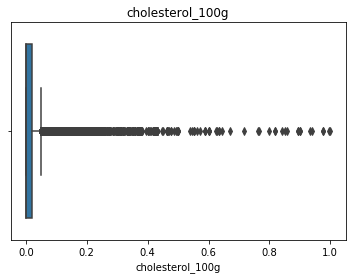

In [19]:
plot_boxplot(food_df,'cholesterol_100g')

In [16]:
non_null_num(food_df,'fat_100g')

Total number of not null elements: 586719
Percentage of the total: 84.54


In [12]:
food_df[food_df['fat_100g'].notnull()][['fat_100g']].describe()

,fat_100g
count,586719.000000
mean,13.636445
std,112.227224
min,0.000000
25%,0.500000
50%,6.300000
75%,21.000000
max,66700.000000


In [17]:
indexes_fat = food_df.loc[food_df['fat_100g'] > 100].index
clean_columns(indexes_fat, food_df, 'fat_100g')
food_df.fat_100g.describe()

count    586719.000000
mean         13.245639
std          17.412664
min           0.000000
25%           0.500000
50%           6.300000
75%          21.000000
max         100.000000
Name: fat_100g, dtype: float64

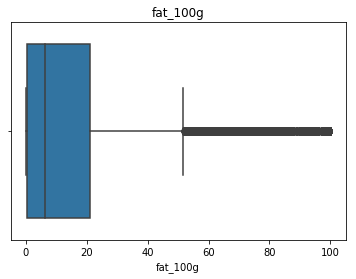

In [20]:
plot_boxplot(food_df,'fat_100g')

In [6]:
countries = food_df.groupby(food_df['countries']).sum()
countries

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_uk,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,calcium_100g,carbon-footprint_100g,nutrition-score-uk_100g
countries,,,,,,,,,,,,,,,,,,
Afrique du Sud,82.0,1.0,0.0,22608.00,308.720,121.760,41.04,31.92,0.0872,445.700,195.400,50.300,177.870,10.128782,112.0,0.000513,0.0,165.0
"Afrique du Sud,Swaziland",6.0,0.0,0.0,131.00,0.000,0.000,0.00,0.00,0.0000,8.000,7.900,0.000,0.000,0.005080,0.0,0.000000,0.0,1.0
Albania,1.0,0.0,0.0,2119.00,15.100,6.700,0.00,0.00,0.0000,75.800,19.300,0.000,14.400,2.805429,4.5,0.005400,0.0,23.0
"Albania,France",0.0,0.0,0.0,1720.00,11.000,0.700,0.00,0.00,0.0000,66.000,16.000,9.000,7.500,0.300000,0.0,0.000000,0.0,0.0
"Albania,Italia",0.0,0.0,0.0,0.00,0.000,0.000,0.00,0.00,0.0000,0.000,0.000,0.000,0.000,0.000000,0.0,0.000000,0.0,0.0
"Albania,Italy",2.0,0.0,0.0,1602.00,3.800,0.900,0.00,0.00,0.0000,76.900,42.000,2.500,7.900,0.230124,0.0,0.000000,0.0,12.0
"Albania,Italy,France",0.0,0.0,0.0,272.00,3.600,2.500,0.00,0.00,0.0000,5.000,5.000,0.000,3.300,0.100000,0.0,0.000000,0.0,1.0
"Albanie,France",2.0,0.0,0.0,477.00,0.500,0.200,0.00,0.00,0.0000,21.800,13.800,0.000,3.800,0.610000,0.0,0.000000,0.0,-3.0
"Albanie,France,Italie",0.0,0.0,0.0,1644.00,21.000,13.000,0.00,0.00,0.0000,14.000,0.800,0.000,22.000,0.000000,0.0,0.000000,0.0,14.0


Since the names of the countries are not in the same format and language, I am going to unify the format.

In [7]:
counter = 0

for country in food_df['countries']:
    if type(country) == str:
        country = country.replace(" ","")
        country = country.replace("en:","")
        country = country.replace("UK","great britain")
        country = country.replace("USA","US")
        country = country.split(',')
        
        for j in country:            
            if len(j) == 2:
                try:
                    country[country.index(j)] = pycountry.countries.lookup(j).name
                except:
                    pass
        
        country = ','.join(country)
        country = translate_client.translate(country, target_language='en')['translatedText']
        country = country.lower()
        food_df['countries'].at[counter] = country
    counter +=1

countries = food_df.groupby(food_df['countries']).sum()
countries

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_uk,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,calcium_100g,carbon-footprint_100g,nutrition-score-uk_100g
countries,,,,,,,,,,,,,,,,,,
afghanistan,0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.00000,0.000,0.000,0.000,0.00,0.000000,0.00,0.0000,0.0,0.0
"afghanistan, france",0.0,0.0,0.0,71.00,0.000,0.000,0.0,0.0,0.00000,3.800,2.800,0.000,0.00,0.000000,0.00,0.0000,0.0,0.0
"afriquedusud, swaziland",6.0,0.0,0.0,131.00,0.000,0.000,0.0,0.0,0.00000,8.000,7.900,0.000,0.00,0.005080,0.00,0.0000,0.0,1.0
albania,1.0,0.0,0.0,2681.00,19.100,6.800,0.0,0.0,0.00000,97.200,35.700,0.000,18.30,2.845429,16.70,0.1254,0.0,20.0
"albania, denmark, italy",0.0,0.0,0.0,401.00,0.800,0.000,0.0,0.0,0.00000,15.300,1.000,0.000,7.50,0.800100,0.00,0.0000,0.0,0.0
"albania, france",2.0,0.0,0.0,2197.00,11.500,0.900,0.0,0.0,0.00000,87.800,29.800,9.000,11.30,0.910000,0.00,0.0000,0.0,-3.0
"albania, france, italy",0.0,0.0,0.0,1644.00,21.000,13.000,0.0,0.0,0.00000,14.000,0.800,0.000,22.00,0.000000,0.00,0.0000,0.0,14.0
"albania, italy",2.0,0.0,0.0,3099.00,5.800,1.300,0.0,0.0,0.00000,149.400,43.000,5.000,17.90,0.234112,0.00,0.0000,0.0,9.0
"albania, kosovo",0.0,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.00000,0.000,0.000,0.000,0.00,0.000000,0.00,0.0000,0.0,0.0


In [10]:
food_df['origins'] = food_df['origins'].fillna("unknown")
origins = food_df.groupby(food_df['origins']).sum()
origins

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_uk,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,calcium_100g,carbon-footprint_100g,nutrition-score-uk_100g
origins,,,,,,,,,,,,,,,,,,
Perú,0.0,0.0,0.0,1563.00,1.380,0.21,0.00,0.00,0.0000,61.30,5.90,21.3,22.300,0.42000,0.0,0.0000,0.0,-4.0
&quot;Produit d'importation&quot;,1.0,0.0,0.0,1883.00,23.000,1.80,0.00,0.00,0.0000,49.90,42.70,0.0,8.900,0.10000,0.0,0.0000,0.0,15.0
(Québec) CND,0.0,0.0,0.0,1530.00,26.700,20.00,0.00,0.00,0.0833,3.33,0.00,0.0,23.300,1.78000,0.0,0.6670,0.0,21.0
(Türkei ?),0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.0,0.000,0.00000,0.0,0.0000,0.0,0.0
"//Ingrediente y envasador (Los Portales S.A.)://,Ciego Montero,Palmira,Cienfuegos,Cuba",0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.0,0.000,0.00000,0.0,0.0112,0.0,0.0
"//Ingrediente(s)://,Castilla-La Mancha,España,//Fabricante y envasador (Agrícola Casa de la Viña S.A.)://,Alhambra,Ciudad Real (provincia),Castilla-La Mancha,España",0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.0,0.000,0.00000,13.5,0.0000,0.0,0.0
"//Ingrediente(s)://,Desconocido,//Fabricante y envasador (Soria Natural S.A.)://,Garray,Soria (provincia),Castilla y León,España",0.0,0.0,0.0,1480.92,28.360,3.30,7.56,17.50,0.0000,0.44,0.00,0.0,24.970,1.19380,0.0,0.0000,0.0,0.0
0,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.0,0.327,0.00000,0.0,0.0000,0.0,0.0
03/2018,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.00,0.0000,0.00,0.00,0.0,0.000,0.00000,0.0,0.0000,0.0,0.0


In [11]:
food_df['ingredients_text'] = food_df['ingredients_text'].fillna("unknown")
ingredients = food_df.groupby(food_df['ingredients_text']).sum()
ingredients

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_uk,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,calcium_100g,carbon-footprint_100g,nutrition-score-uk_100g
ingredients_text,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,5443.000,87.80,21.600,0.00,0.0,0.000,156.10,101.81,4.51,40.200,5.927676,0.0,0.0000,0.0,57.0
,0.0,0.0,0.0,587.000,9.20,5.400,0.00,0.0,0.000,10.30,1.90,1.50,3.500,1.220000,0.0,0.0000,0.0,10.0
,0.0,0.0,0.0,9114.000,152.00,47.490,0.00,0.0,0.000,139.00,103.70,3.10,56.800,9.892000,0.0,0.0000,0.0,55.0
,0.0,0.0,0.0,197.000,1.52,1.000,0.52,0.0,0.008,4.40,3.52,0.20,3.800,0.118000,0.0,0.1140,0.0,-2.0
,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.0,0.000,0.00,0.00,0.00,0.000,0.000000,0.0,0.0000,0.0,0.0
,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.0,0.000,0.00,0.00,0.00,0.000,0.000000,0.0,0.0000,0.0,0.0
,0.0,0.0,0.0,2257.000,38.00,20.000,0.00,0.0,0.000,40.00,37.00,0.00,6.900,0.020000,0.0,0.0000,0.0,24.0
,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.0,0.000,0.00,0.00,0.00,0.000,0.000000,0.0,0.0000,0.0,0.0
"G) Sucre ; blé soufflé : blé (contient gluten) 55%, sucre, sirop de glucose, miel, huile de colza, sirop de sucre caramélisé ; graisses végétales (palme. karité), lait entier en poudre 13%, beurre de cacao, lait écrémé en poudre. lactose (contient lait), pâte de Cacao, lactosérum en poudre (contient lait) ; émulsifiant : lécithines; extrait de vanille. Traces éventuelles de fruits a coque, d‘arachides et de soja. ‘ Cacao : 30% minimum dans le chocolat au lait. Elaboré à partir de lait origine U. l",1.0,1.0,0.0,2232.000,30.00,24.000,0.00,0.0,0.000,58.00,45.00,1.50,7.300,0.150000,0.0,0.0000,0.0,24.0


This column doesn't contain the allergens name, we need to change this one by other

In [15]:
food_df['additives_en'] = food_df['additives_en'].fillna("unknown")
additives = food_df.groupby(food_df['additives_en']).sum()
additives

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_uk,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,calcium_100g,carbon-footprint_100g,nutrition-score-uk_100g
additives_en,,,,,,,,,,,,,,,,,,
E100 - Curcumin,118.0,2.0,0.0,1.435570e+05,1.597870e+03,3.721090e+02,62.09000,50.9400,0.31630,4.131050e+03,1.159889e+03,2.000850e+02,8.563100e+02,3.240442e+02,0.00,1.905000,0.000000,415.0
"E100 - Curcumin,E1000 - Cholic acid,E141 - Copper complexes of chlorophylls and chlorophyllins,E160c - Paprika extract,E163 - Anthocyanins,E330 - Citric acid",6.0,0.0,0.0,1.531000e+03,0.000000e+00,0.000000e+00,0.00000,0.0000,0.00000,9.150000e+01,7.720000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000,0.000000,0.0
"E100 - Curcumin,E1000 - Cholic acid,E160a - Alpha-carotene,E163 - Anthocyanins,E171 - Titanium dioxide,E202 - Potassium sorbate,E297 - Fumaric acid,E330 - Citric acid,E331 - Sodium citrates,E422 - Glycerol,E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E901 - White and Yellow Beeswax,E903 - Carnauba wax,E904 - Shellac",14.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.0000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000,0.000000,26.0
"E100 - Curcumin,E1001 - Choline salt,E120 - Cochineal,E141 - Copper complexes of chlorophylls and chlorophyllins,E160a - Alpha-carotene,E163 - Anthocyanins",6.0,0.0,0.0,1.615000e+03,1.000000e+00,1.000000e+00,0.00000,0.0000,0.00000,9.600000e+01,7.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.00,0.000000,0.000000,0.0
"E100 - Curcumin,E1001 - Choline salt,E1400 - Dextrin,E322 - Lecithins,E322i - Lecithin,E343 - Magnesium phosphates",5.0,0.0,0.0,1.004000e+03,9.400000e+00,9.000000e-01,0.00000,0.0000,0.00000,2.440000e+01,1.330000e+01,0.000000e+00,1.440000e+01,1.000000e-01,0.00,0.000000,0.000000,-1.0
"E100 - Curcumin,E101 - Riboflavin,E101i - Riboflavin,E102 - Tartrazine,E110 - Sunset yellow FCF,E120 - Cochineal,E129 - Allura red ac,E133 - Brilliant blue FCF,E141 - Copper complexes of chlorophylls and chlorophyllins,E150d - Sulphite ammonia caramel,E160a - Alpha-carotene,E163 - Anthocyanins,E171 - Titanium dioxide,E270 - Lactic acid,E296 - Malic acid,E325 - Sodium lactate,E330 - Citric acid,E428 - Gelatine,E440 - Pectins,E440i - Pectin",18.0,0.0,0.0,1.422000e+03,0.000000e+00,0.000000e+00,0.00000,0.0000,0.00000,8.020000e+01,6.250000e+01,0.000000e+00,4.000000e+00,1.000000e-01,0.00,0.000000,0.000000,14.0
"E100 - Curcumin,E101 - Riboflavin,E101i - Riboflavin,E120 - Cochineal,E131 - Patent blue v,E133 - Brilliant blue FCF,E141 - Copper complexes of chlorophylls and chlorophyllins,E160 - Carotene,E160c - Paprika extract,E161b - Lutein,E171 - Titanium dioxide,E172 - Iron oxides and iron hydroxides,E322 - Lecithins,E413 - Tragacanth,E901 - White and Yellow Beeswax,E904 - Shellac",15.0,1.0,0.0,0.000000e+00,5.300000e+00,3.000000e+00,0.00000,0.0000,0.00000,9.070000e+01,8.030000e+01,0.000000e+00,8.000000e-01,5.000000e-02,0.00,0.000000,0.000000,0.0
"E100 - Curcumin,E101 - Riboflavin,E101i - Riboflavin,E120 - Cochineal,E131 - Patent blue v,E171 - Titanium dioxide,E322 - Lecithins,E330 - Citric acid,E901 - White and Yellow Beeswax,E903 - Carnauba wax,E904 - Shellac",10.0,0.0,0.0,1.733000e+03,4.500000e+00,2.700000e+00,0.00000,0.0000,0.00000,9.100000e+01,7.500000e+01,0.000000e+00,1.100000e+00,5.000000e-02,0.00,0.000000,0.000000,17.0
"E100 - Curcumin,E101 - Riboflavin,E101i - Riboflavin,E120 - Cochineal,E132 - Indigotine,E133 - Brilliant blue FCF,E150c - Ammonia caramel,E150d - Sulphite ammonia caramel,E153 - Vegetable carbon,E160a - Alpha-carotene,E160aii - Plant carotenes,E160c - Paprika extract,E162 - Beetroot red,E163 - Anthocyanins,E330 - Citric acid,E414 - Acacia gum,E415 - Xanthan gum,E466 - Sodium carboxy methyl cellulose,E641 - E641 food additive,E950 - Acesulfame k,E952 - Cyclamic acid and its Na and Ca salt

Maybe we could parse each additive name row in order to obtain the most used additive on the food.

It's supposed the sufix \_100g indicates the amount of nutriment (in g, or kJ for energy) for 100 g or 100 ml of product. So, let'see the main statistics values of each \_100g field

Is it possible have, for example, a maximum value higher than 100g ? 

In [18]:
food_df['proteins_100g'].describe()

count    590697.000000
mean          8.187226
std          64.227382
min        -800.000000
25%           1.000000
50%           5.400000
75%          11.000000
max       31000.000000
Name: proteins_100g, dtype: float64

Is impossible to hace a negative value!

In [19]:
food_df['fiber_100g'].describe()

count    2.736270e+05
mean     2.036346e+04
std      1.064819e+07
min     -2.000000e+01
25%      0.000000e+00
50%      1.500000e+00
75%      3.600000e+00
max      5.570000e+09
Name: fiber_100g, dtype: float64

The values here are so huge and again we have negative values

The maximun value again is higher than 100g.

In [21]:
food_df['carbohydrates_100g'].describe()

count    586457.000000
mean         30.989883
std         273.626685
min           0.000000
25%           3.900000
50%          16.670000
75%          55.000000
max       86700.000000
Name: carbohydrates_100g, dtype: float64

In [22]:
food_df['sugars_100g'].describe()

count    576107.000000
mean         15.775378
std         194.921331
min         -17.860000
25%           0.810000
50%           4.400000
75%          21.820000
max       86700.000000
Name: sugars_100g, dtype: float64

In [23]:
food_df['salt_100g'].describe()

count    570941.000000
mean          3.282637
std         511.943315
min           0.000000
25%           0.065000
50%           0.543560
75%           1.353820
max      348000.000000
Name: salt_100g, dtype: float64

In [24]:
food_df['alcohol_100g'].describe()

count    7900.000000
mean        7.049163
std        10.381637
min         0.000000
25%         0.000000
50%         4.500000
75%        12.000000
max       100.000000
Name: alcohol_100g, dtype: float64

In [25]:
food_df['calcium_100g'].describe()

count    143447.000000
mean          0.186045
std           5.408484
min           0.000000
25%           0.000000
50%           0.036000
75%           0.111000
max         779.000000
Name: calcium_100g, dtype: float64

In [26]:
food_df['saturated-fat_100g'].describe()

count    560845.000000
mean          5.350258
std          42.536200
min           0.000000
25%           0.100000
50%           1.800000
75%           7.300000
max       18000.000000
Name: saturated-fat_100g, dtype: float64

In [27]:
food_df['polyunsaturated-fat_100g'].describe()

count    23782.000000
mean         6.480789
std         11.416043
min          0.000000
25%          0.000000
50%          2.330000
75%          7.500000
max        417.000000
Name: polyunsaturated-fat_100g, dtype: float64

In [28]:
food_df['monounsaturated-fat_100g'].describe()

count    23742.000000
mean        10.800748
std         18.918224
min          0.000000
25%          0.210000
50%          4.100000
75%         10.710000
max       1250.000000
Name: monounsaturated-fat_100g, dtype: float64

In [29]:
food_df['carbon-footprint_100g'].describe()

count     343.000000
mean      270.737363
std       404.925091
min        -0.000281
25%         0.875000
50%       150.000000
75%       337.500000
max      2842.000000
Name: carbon-footprint_100g, dtype: float64

In [30]:
food_df['nutrition-score-uk_100g'].describe()

count    140196.000000
mean          8.817555
std           9.378033
min         -15.000000
25%           1.000000
50%           8.000000
75%          17.000000
max          40.000000
Name: nutrition-score-uk_100g, dtype: float64

In [31]:
food_df['nutrition_grade_uk'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: nutrition_grade_uk, dtype: float64

In [32]:
food_df['additives_n'].describe()

count    393385.000000
mean          1.573398
std           2.302268
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          30.000000
Name: additives_n, dtype: float64